In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

mat_data_set = [()]
# Load MATLAB file
mat_file = r'C:\Device5_ 1.mat' 
mat_data = scipy.io.loadmat(mat_file)
mat_data_set = np.append(mat_data_set, mat_data)

mat_file = r'C:\Device2  1.mat' 
mat_data = scipy.io.loadmat(mat_file)
mat_data_set = np.append(mat_data_set, mat_data)

mat_file = r'C:\Device3  1.mat' 
mat_data = scipy.io.loadmat(mat_file)
mat_data_set = np.append(mat_data_set, mat_data)

mat_file = r'C:\Device4  1.mat' 
mat_data = scipy.io.loadmat(mat_file)
mat_data_set = np.append(mat_data_set, mat_data)

#j=0 dev5
#j=1 dev2
#j=2 dev3
#j=3 dev4

ce_window_smooth = [None] * len(mat_data_set)

for j in range(len(mat_data_set)):
    measurement = mat_data_set[j]['measurement']
    transient = measurement['transient']
    
    total_time = 0
    new_time = 0
    original = 0 
    time = np.array([])
    ce_data_list = []
    
    for i in range(len(transient[0,0][0])):
        date_str = transient[0,0][0][i][0][0]
        time_str = date_str.split(' ')[1]
        hour, minute, second = map(int, time_str.split(':'))
        
        new_time = hour*3600 + minute*60 + second
        if i == 0:
            original = new_time
        total_time = new_time - original
    
        time = np.append(time, total_time)
        
        ce_data = transient[0,0][0][i][2][0][0][3][0]
        ce_data_list.append(ce_data)
    
    ce_data_array = np.array(ce_data_list) 
    
    ce_sampling_data = [()]
    for i in range(len(ce_data_array)):
        if time[i]>=2000 and np.min(ce_data_array[i])<=4.0:
            break
        ce_sampling_data = np.append(ce_sampling_data, np.average(ce_data_array[i]))
    
    def calculate_weighted_average(x, t, span=15):
        theta = 2 / (span + 1)
        numerator = 0
        denominator = 0
    
        for i in range(t + 1):
            weight = (1 - theta) ** (t - i)
            numerator += weight * x[i]
            denominator += weight
    
        yt = numerator / denominator
        return yt
    
    span = 15
    ce_window_smooth[j] = np.zeros(len(ce_sampling_data))
    for t in range(len(ce_sampling_data)):
        ce_window_smooth[j][t] = calculate_weighted_average(ce_sampling_data, t, span)

print("Done")

Done


In [2]:
for q in range(len(mat_data_set)):
    len_ori = len(ce_window_smooth[q])
    print(len_ori)

103
106
96
91


In [3]:
ce_window_smooth_new = [None]*len(mat_data_set)
len_larger = len(ce_window_smooth[3])
for q in range(len(mat_data_set)):
    ce_window_smooth_new[q] = ce_window_smooth[q][0:len_larger]
    #print(len(output_array_new[q])-len(ce_window_smooth[q])

In [4]:
for q in range(len(mat_data_set)):
    len_ori = len(ce_window_smooth_new[q])
    print(len_ori)

91
91
91
91


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the feedforward neural network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First layer
        self.relu = nn.ReLU()                        # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size) # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Data matrix
data = torch.tensor(ce_window_smooth_new, dtype=torch.float32)

# Hyperparameters
input_size = 1  # Train using individual elements
hidden_size = 5  # Number of neurons in the hidden layer
output_size = 1  # Predict single elements
learning_rate = 0.01
num_epochs = 100

# Initialize the model, loss function, and optimizer
model = FeedForwardNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Train the model using individual elements from rows 1, 2, and 3
    for row_idx in [1, 2, 3]:
        for col_idx in range(data.size(1)):  # Iterate through each element in the row
            X_train = data[row_idx, col_idx].view(1, 1)  # Single element as input
            y_train = X_train.clone()                   # Target is the input itself

            # Forward pass
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
    
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

        # Print loss every 50 epochs for each element
        #if (epoch + 1) % 50 == 0:
           # print(f'Row {row_idx}, Element {col_idx}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

output_arr =[]
# Test the model using individual elements from row 0
with torch.no_grad():
    for col_idx in range(data.size(1)):
        X_test = data[0, col_idx].view(1, 1)  # Single element as input
        prediction = model(X_test)
        output_arr.append(prediction.item()) 
        #print(f'Input: {X_test.item()}, Prediction: {prediction.item()}, Target: {X_test.item()}')


TypeError: list.append() takes exactly one argument (2 given)

In [18]:
output_arr = []
# Test the model using individual elements from row 0
with torch.no_grad():
    for col_idx in range(data.size(1)):
        X_test = data[0, col_idx].view(1, 1)  # Single element as input
        prediction = model(X_test)
        output_arr.append(prediction.item()) 
        #print(f'Input: {X_test.item()}, Prediction: {prediction.item()}, Target: {X_test.item()}')

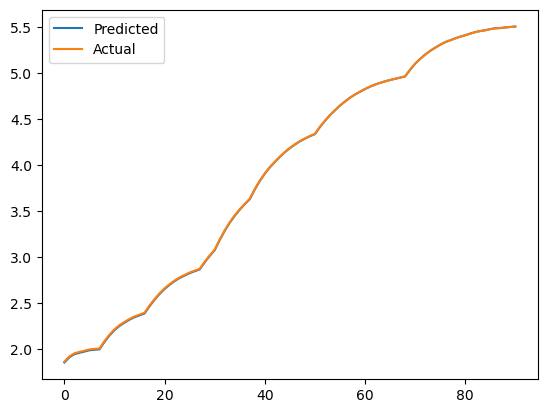

In [20]:
# Plot results
plt.plot(output_arr, label='Predicted')
plt.plot(ce_window_smooth_new[0], label='Actual')
plt.legend()
plt.show()

In [21]:
type(output_arr)

list

In [25]:
import numpy as np

# Function to calculate MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Function to calculate R² (Coefficient of Determination)
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Function to calculate MAE
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

print("Done")

Done


In [26]:
y_true = ce_window_smooth_new[0]

y_pred = output_arr
# Calculate MSE
mse_cnnlstm = mean_squared_error(y_true, y_pred)

# Calculate R²
r2_cnnlstm = r2_score(y_true, y_pred)*100

# Calculate MAE
mae_cnnlstm = mean_absolute_error(y_true, y_pred)

print(mse_cnnlstm)
print(r2_cnnlstm)
print(mae_cnnlstm)

2.7670155675900642e-05
99.99814963468809
0.004056782814239644
